In [1]:
# imports
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import re
import math
import matplotlib.pyplot as plt
import bezier as bz
from scipy.stats import norm

# Olmsted Park Data From Rhino

In [2]:
# helper function for XML parsing
def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

# import points and connections XML files from Rhino
ptree = ET.parse("C:\\Users\\Joseph Bentivegna\\Downloads\\point (prospect park).xml")
ctree = ET.parse("C:\\Users\\Joseph Bentivegna\\Downloads\\point-points (prospect park).xml")

# initialize dataframe
pcols = ['full', 'x', 'y', 'conn', 'connindex']
points = pd.DataFrame(columns=pcols)

# iteratre through XML files and extract necessary point and connection information
for node in ptree.getroot():
    vals = node.find('Item')
    xyz = getvalueofnode(vals)
    xyz = xyz.replace("{", "").replace("}", "").split(',')
    points = points.append(pd.Series([xyz, xyz[0], xyz[1], [], []], index=pcols), ignore_index=True)

for conn in ctree.getroot():
    curpoint = int(conn.tag.split('-')[1])
    vals = conn.find('Item')
    xyz = getvalueofnode(vals)
    xyz = xyz.replace("{", "").replace("}", "").split(',')
    xyzindex = points[np.logical_and(points['x'] == xyz[0], points['y'] == xyz[1])].index.values[0]
    
    points['conn'][curpoint].append(xyz)
    points['connindex'][curpoint].append(xyzindex)    
    
points.head(10)

full             x             y  \
0  [-2613.789458,  1952.677337,  0]  -2613.789458   1952.677337   
1   [-2329.388613,  1664.50352,  0]  -2329.388613    1664.50352   
2    [-852.01891,  3285.603941,  0]    -852.01891   3285.603941   
3   [-840.893442,  3198.454443,  0]   -840.893442   3198.454443   
4    [-873.342723,  3341.23128,  0]   -873.342723    3341.23128   
5   [-881.686824,  3382.951785,  0]   -881.686824   3382.951785   
6   [-896.520781,  3492.352218,  0]   -896.520781   3492.352218   
7   [-902.083515,  3542.416824,  0]   -902.083515   3542.416824   
8   [-918.771717,  3669.432581,  0]   -918.771717   3669.432581   
9   [-916.917472,  3379.243295,  0]   -916.917472   3379.243295   

                                                conn           connindex  
0  [[-2329.388613,  1664.50352,  0], [-2516.62468...  [1, 307, 300, 431]  
1  [[-2613.789458,  1952.677337,  0], [-2195.0587...       [0, 328, 433]  
2  [[-840.893442,  3198.454443,  0], [-873.342723...         [3, 4, 570]  
3                   [[-852.01891,  3285.603941,  0]]                 [2]  
4  [[-852.01891,  3285.603941,  0], [-881.686824,...           [2, 5, 9]  
5  [[-873.342723,  3341.23128,  0], [-896.520781,...           [4, 6, 9]  
6  [[-881.686824,  3382.951785,  0], [-902.083515...          [5, 7, 10]  
7  [[-896.520781,  3492.352218,  0], [-918.771717...          [6, 8, 12]  
8  [[-943.80402,  3534.072723,  0], [-902.083515,...             [12, 7]  
9  [[-873.342723,  3341.23128,  0], [-881.686824,...          [4, 5, 10]

In [3]:
# import control points XML file from Rhino
cptree = ET.parse("C:\\Users\\Joseph Bentivegna\\Downloads\\point-curve control points (prospect park).xml")

# initialize dataframe
cpcols = ['node1', 'node2', 'controlpoints']
controlpoints = pd.DataFrame(columns=cpcols)

# iterate through XML file and determine which control points belong to each connection
curconn = ""
for control in cptree.getroot():
    vals = control.find('Item')
    xyz = getvalueofnode(vals)
    xyz = xyz.replace("{", "").replace("}", "").split(',')
    
    if curconn == control.tag:
        controlpoints['controlpoints'][len(controlpoints)-1].append(xyz)
    else:
        node1 = int(control.tag.split('-')[1])
        connection = int(control.tag.split('-')[2])
        node2 = points['connindex'][node1][connection]
        
        controlpoints = controlpoints.append(pd.Series([node1, node2, [xyz]], index=cpcols), ignore_index=True)
    
    curconn = control.tag
    
controlpoints.head()

node1 node2                                      controlpoints
0     0     1  [[-2613.789458,  1952.677337,  0], [-2603.4567...
1     0   307  [[-2516.624685,  2524.667331,  0], [-2524.9738...
2     0   300  [[-2613.789458,  1952.677337,  0], [-2590.3344...
3     0   431  [[-2803.849533,  1861.81935,  0], [-2740.48924...
4     1     0  [[-2613.789458,  1952.677337,  0], [-2603.4567...

In [4]:
# park plotting function for Rhino data
def plot_park(points):
    
    points['x'] = points['x'].astype(float)
    points['y'] = points['y'].astype(float)
    
    fig, ax = plt.subplots(figsize=(16,10))
#     ax.set_aspect('equal')
    for ii in range(len(points)):
        for conn in points['connindex'][ii]:
            xs = [points['x'][ii], points['x'][conn]]
            ys = [points['y'][ii], points['y'][conn]]
            plt.plot(xs, ys, 'r')

    plt.show()

In [5]:
# park plotting function with bezier curves for Rhino data
def plot_bezier_park(points, controlpoints):

    fig, ax = plt.subplots(figsize=(16,10))
    for ii in range(len(controlpoints)):
        xs = [float(k[0]) for k in controlpoints['controlpoints'][ii]]
        ys = [float(k[1]) for k in controlpoints['controlpoints'][ii]]
        points = np.asfortranarray([xs, ys])

        curve = bz.Curve(points, degree=len(controlpoints['controlpoints'][ii]))
        
        _ = curve.plot(num_pts=256, ax=ax)
      
        
    plt.show()

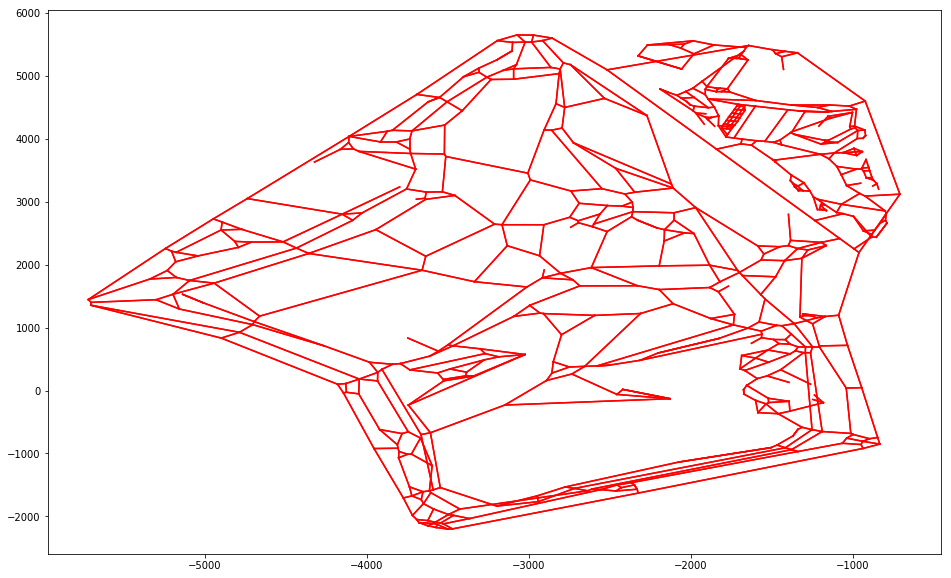

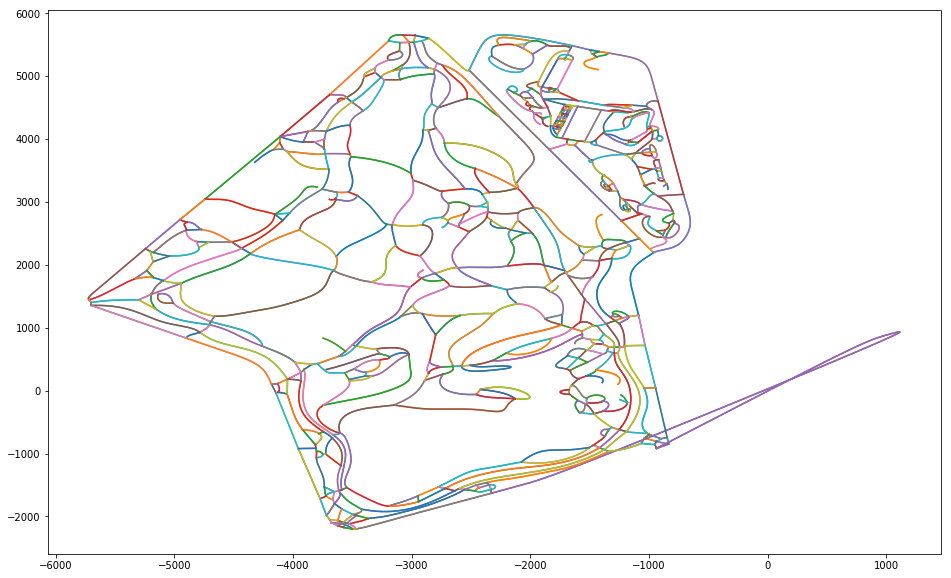

In [6]:
plot_park(points)
plot_bezier_park(points, controlpoints)

# Generator Function

In [7]:
# function that generates random parks given input boundaries and number of nodes
def generator(x_bounds, y_bounds, num_nodes=15):
    nodes = []
    i_nodes = []
    distances = []
    paths = []
    bezier = []
    
    # loop to create nodes randomly and calculate distance between all nodes
    for ii in range(num_nodes):
        
        x = (x_bounds[1] - x_bounds[0]) * np.random.random_sample() - x_bounds[1]
        y = (y_bounds[1] - y_bounds[0]) * np.random.random_sample() - y_bounds[1]
       
        temp = []
        for node in nodes:
            temp.append(math.sqrt(((node[0]-x)**2)+((node[1]-y)**2)))
        distances.append(temp)
            
        nodes.append([x,y])
        i_nodes.append(ii)
    
    # loop to create connections between nodes based off of their relative distance
    # nodes that are closer have a higher chance of being connected
    for jj in range(num_nodes):
        
        if jj<num_nodes-1:
            list_of_dist = distances[jj] + [bleh[jj] for bleh in distances[jj+1:]]
        else:
            list_of_dist = distances[jj]
            
        #print(list_of_dist)
        list_sum = sum(list_of_dist)
        #print(list_sum)
        inverted_list = [(list_sum/bleh) for bleh in list_of_dist]
        list_sum = sum(inverted_list)
        normalized_list_1 = [blah/list_sum for blah in inverted_list]
        #print(normalized_list)
        node_choice = np.random.choice((i_nodes[:jj] + i_nodes[jj+1:]), p=normalized_list_1)
        #print(node_choice[0]-1)
        paths.append([jj, node_choice])
        #print(normalized_list)        
        normalized_list_1[node_choice-1] = 0
        #print(normalized_list)
        list_sum = sum(normalized_list_1)
        normalized_list_2 = [(bloh/list_sum) for bloh in normalized_list_1]
        #print(normalized_list)
        paths.append([jj, np.random.choice((i_nodes[:jj] + i_nodes[jj+1:]), p=normalized_list_2)])

    # loop to add 2 control points to each connection
    for path in paths:
        
        node1 = nodes[int(path[0])]
        node2 = nodes[int(path[1])]
        
        control_v = np.random.normal((node1[0] + node2[0])/3, np.absolute(node1[0] - node2[0])/2, 1)
        control_w = np.random.normal((node1[1] + node2[1])/3, np.absolute(node1[1] - node2[1])/2, 1)
        
        control_x = np.random.normal(2*(node1[0] + node2[0])/3, np.absolute(node1[0] - node2[0])/2, 1)
        control_y = np.random.normal(2*(node1[1] + node2[1])/3, np.absolute(node1[1] - node2[1])/2, 1)
        
        bezier.append([[node1[0], control_v[0], control_x[0], node2[0]], [node1[1], control_w[0], control_y[0], node2[1]]])
    
    return nodes, paths, bezier

# Heuristic Function

[(70, 550), (123, 511), (161, 474), (186, 440), (198, 406), (199, 374), (192, 342), (177, 309), (157, 277), (133, 244), (107, 209), (80, 172), (54, 134), (31, 92), (12, 48), (0, 0)]


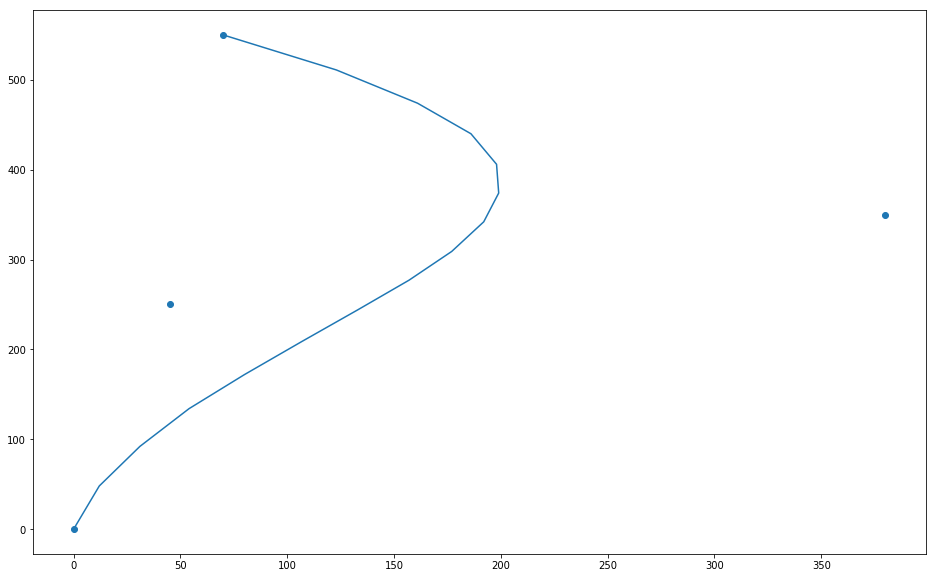

In [8]:
# helper function to approximate cubic bezier curves
# this allows our calculation of the path length and curviness

def approx_cubic_bez(p1, p2, p3, p4):
    lp = []
    num = 15
    for i in range(num):
        t = i / num
        t2 = t*t
        t3 = t2*t
        mt = 1-t
        mt2 = mt*mt
        mt3 = mt2*mt
        x = int(p1[0]*mt3 + 3*p2[0]*mt2*t + 3*p3[0]*mt*t2 + p4[0]*t3)
        y = int(p1[1]*mt3 + 3*p2[1]*mt2*t + 3*p3[1]*mt*t2 + p4[1]*t3)
        lp.append((x,y))
        
    lp.append(p4)
    return lp
    
# plotting example for sanity check
outs = approx_cubic_bez((70, 550), (380, 350), (45, 250), (0, 0))
print (outs)
fig, ax = plt.subplots(figsize=(16,10))
plt.scatter([70, 380, 45, 0], [550, 350, 250, 0])
plt.plot([p[0] for p in outs], [p[1] for p in outs])
plt.show()

In [10]:
# helper function to solve for the area of intersection between two normal distributions

def solve(m1,m2,std1,std2):
    a = 1./(2.*std1**2) - 1./(2.*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    result = np.roots([a, b, c])
    
    lower = -5000
    upper = 5000
    if(len(result)==0): # Completely non-overlapping 
        overlap = 0.0

    elif(len(result)==1): # One point of contact
        r = result[0]
        if(m1>m2):
            tm,ts=m2,std2
            m2,std2=m1,std1
            m1,std1=tm,ts
        if(r<lower): # point of contact is less than the lower boundary. order: r-l-u
            overlap = (norm.cdf(upper,m1,std1)-norm.cdf(lower,m1,std1))
        elif(r<upper): # point of contact is more than the upper boundary. order: l-u-r
            overlap = (norm.cdf(r,m2,std2)-norm.cdf(lower,m2,std2))+(norm.cdf(upper,m1,std1)-norm.cdf(r,m1,std1))
        else: # point of contact is within the upper and lower boundaries. order: l-r-u
            overlap = (norm.cdf(upper,m2,std2)-norm.cdf(lower,m2,std2))

    elif(len(result)==2): # Two points of contact
        r1 = result[0]
        r2 = result[1]
        if(r1>r2):
            temp=r2
            r2=r1
            r1=temp
        if(std1>std2):
            tm,ts=m2,std2
            m2,std2=m1,std1
            m1,std1=tm,ts
        if(r1<lower):
            if(r2<lower):           # order: r1-r2-l-u
                overlap = (norm.cdf(upper,m1,std1)-norm.cdf(lower,m1,std1))
            elif(r2<upper):         # order: r1-l-r2-u
                overlap = (norm.cdf(r2,m2,std2)-norm.cdf(lower,m2,std2))+(norm.cdf(upper,m1,std1)-norm.cdf(r2,m1,std1))
            else:                   # order: r1-l-u-r2
                overlap = (norm.cdf(upper,m2,std2)-norm.cdf(lower,m2,std2))
        elif(r1<upper): 
            if(r2<upper):         # order: l-r1-r2-u
                overlap = (norm.cdf(r1,m1,std1)-norm.cdf(lower,m1,std1))+(norm.cdf(r2,m2,std2)-norm.cdf(r1,m2,std2))+(norm.cdf(upper,m1,std1)-norm.cdf(r2,m1,std1))
            else:                   # order: l-r1-u-r2
                overlap = (norm.cdf(r1,m1,std1)-norm.cdf(lower,m1,std1))+(norm.cdf(upper,m2,std2)-norm.cdf(r1,m2,std2))
        else:                       # l-u-r1-r2
            overlap = (norm.cdf(upper,m1,std1)-norm.cdf(lower,m1,std1))
    
    return overlap

In [9]:
# function to determine coordinates of a bounding box around a plot

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)

    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

In [12]:
# helper function to solve for the angle between 3 points

def angle_between(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [13]:
# helper function to solve for the area of a polygon defined by X, Y coordinates
def polygonArea(X, Y, n): 
  
    # Initialze area 
    area = 0.0
  
    # Calculate value of shoelace formula 
    j = n - 1
    for i in range(0,n): 
        area += (X[j] + X[i]) * (Y[j] - Y[i]) 
        j = i   # j is previous vertex to i 
      
  
    # Return absolute value 
    return int(abs(area / 2.0)) 

In [14]:
# helper function to calculate the distance between a point and two other points

def dist_boundary(a, b, c):    
    p1 = np.asarray(a)
    p2 = np.asarray(b)
    p3 = np.asarray(c)
    return np.cross(p2-p1, p3-p1)/np.linalg.norm(p2-p1)

In [15]:
'''
The heuristic function that evaluates a park based on 3 features:
1. The normalized distribution of the distance a point is from the edge of the park
2. The normalized distribution of length of paths in the park
3. The normalized distribution of “curviness” of paths in the park
the heuristic returns a single value; the higher the value, the more Olmsted-like the park is
'''

def heuristic(nodes, paths, bezier, bounds):
    
    #olmstead metrics
    # -------------------------------
    olmMeanDistBoundary = 0.3
    olmStdDistBoundary = 0.2
    
    olmMeanLineLength = 0.0005
    olmStdLineLength = 0.0005
    
    olmMeanLineCurvy = 2500
    olmStdLineCurvy = 150
    # -------------------------------
    
    # calculate boundary area and centroid
    X = [x[0] for x in bounds]
    Y = [x[1] for x in bounds]
    n = len(X)
    parkArea = polygonArea(X, Y, n)
    
    centroid = (sum(X) / n, sum(Y) / n)
    
    # calculate mean and std of distance of points from boundary    
    nodeDist = []
    for node in nodes:
        try:
            dists = [dist_boundary(bounds[0], bounds[1], node), dist_boundary(bounds[1], bounds[2], node), dist_boundary(bounds[2], bounds[3], node), dist_boundary(bounds[3], bounds[0], node)]
        except: 
            return "INVALID BOUNDARY ORDER: ENTER VALUES IN CONNECTING ORDER"
        minDist = min(dists)
        minDistIndex = dists.index(minDist)
        
        if minDistIndex == 0:
            centDist = dist_boundary(bounds[0], bounds[1], centroid)
        elif minDistIndex == 1:
            centDist = dist_boundary(bounds[1], bounds[2], centroid)
        elif minDistIndex == 2:
            centDist = dist_boundary(bounds[2], bounds[3], centroid)
        elif minDistIndex == 3:
            centDist = dist_boundary(bounds[3], bounds[0], centroid)
            
        normMinDist = minDist / centDist
            
        nodeDist.append(normMinDist)
        
    meanDistBoundary = np.mean(nodeDist)
    stdDistBoundary = np.std(nodeDist)

    # calculate final distance metric: overlaping normal distribution area
    distanceMetric = solve(meanDistBoundary, olmMeanDistBoundary, stdDistBoundary, olmStdDistBoundary)
    
    # calculate mean and std of length of paths, and mean and std of curviness of paths    
    lineLength = []
    lineCurvy = []
    for ii in range(len(bezier)):
        points = list(zip(bezier[ii][0], bezier[ii][1]))
        
        approxPoints = approx_cubic_bez(points[0], points[1], points[2], points[3])
        
        length = 0
        for jj in range(len(approxPoints)-1):
            dist = math.sqrt( (approxPoints[jj][0] - approxPoints[jj+1][0])**2 + (approxPoints[jj][1] - approxPoints[jj+1][1])**2 )
            length = length + dist
            
        curvy = 0
        for jj in range(len(approxPoints)-2):
            curv = angle_between(approxPoints[jj], approxPoints[jj+1], approxPoints[jj+2])
            curvy = curvy + curv
            
        lineLength.append(length/parkArea)
        lineCurvy.append(curvy)
        
    meanLineLength = np.mean(lineLength)
    stdLineLength = np.std(lineLength)

    meanLineCurvy = np.mean(lineCurvy)
    stdLineCurvy = np.std(lineCurvy)

    # calculate final length and curviness metric: overlaping normal distribution area
    lengthMetric = solve(meanLineLength, olmMeanLineLength, stdLineLength, olmStdLineLength)
    curvyMetric = solve(meanLineCurvy, olmMeanLineCurvy, stdLineCurvy, olmStdLineCurvy)
    
    return distanceMetric + lengthMetric + curvyMetric

# Perturber Function

In [1]:
# this function perturbes the parks by adding random noise to each point and control points
# the ammount of perturbing should be tuned in a later iteration

def perturber(nodes, paths, bezier, bounds):
    
    perturb_ratio = 0.00001
    
    new_nodes = nodes.copy()
    new_bezier = bezier.copy()
    
    X = [x[0] for x in bounds]
    Y = [x[1] for x in bounds]
    n = len(X)
    parkArea = polygonArea(X, Y, n)

    old_nodes = nodes.copy()
    old_bezier = bezier.copy()

    for ii in range(len(new_nodes)):
        theta1 = np.random.uniform(0, 1)*2*np.pi
        r1 = np.random.normal(perturb_ratio*parkArea, perturb_ratio*parkArea/2)
    
        new_x = new_nodes[ii][0] + (r1*np.cos(theta1))
        new_y = new_nodes[ii][1] + (r1*np.sin(theta1))

        new_nodes[ii] = [new_x, new_y]

    for ii in range(len(new_bezier)):
        points = list(zip(new_bezier[ii][0], new_bezier[ii][1]))

        for jj in range(len(points)):
            try:
                old_ind = old_nodes.index(list(points[jj]))
                new_bezier[ii][0][jj] = new_nodes[old_ind][0]
                new_bezier[ii][1][jj] = new_nodes[old_ind][1]

            except:
                theta1 = np.random.uniform(0, 1)*2*np.pi
                r1 = np.random.normal(perturb_ratio*parkArea, perturb_ratio*parkArea/2)

                new_x = new_bezier[ii][0][jj] + (r1*np.cos(theta1))
                new_y = new_bezier[ii][1][jj] + (r1*np.sin(theta1))

                new_bezier[ii][0][jj] = new_x
                new_bezier[ii][1][jj] = new_y
                    
    return new_nodes, paths, new_bezier

# Plotting and Testing

In [140]:
# plotting function for points and connections of our generated parks
def plot_park(nodes, paths, name='bleh'):
    
    fig, ax = plt.subplots(figsize=(16,10))
    for ii in range(len(paths)):
        xs = [nodes[int(paths[ii][0])][0], nodes[int(paths[ii][1])][0]]
        ys = [nodes[int(paths[ii][0])][1], nodes[int(paths[ii][1])][1]]
        plt.plot(xs, ys, 'k-')
    
#     box = bounding_box(nodes)
    plt.axvline(x=-250, color='black')
    plt.axvline(x=250, color='black')
    plt.axhline(y=-1250, color='black')
    plt.axhline(y=1250, color='black')
    plt.axis('equal')
    plt.savefig('C:\\Users\\Joseph Bentivegna\\Documents\\Parks for Aden (lines)\\' + str(name) + '.png', format='png', dpi=500)
    plt.show()

In [141]:
# plotting function for points, connections, and control points of our generated parks
def plot_bezier_park(bezier, degree, name='bleh'):

    fig, ax = plt.subplots(figsize=(16,10))
    for ii in range(len(bezier)):
        points = np.asfortranarray(bezier[ii])
        curve = bz.Curve(points, degree=degree)
        _ = curve.plot(num_pts=256, ax=ax, color='black')
     
    plt.axvline(x=-250, color='black')
    plt.axvline(x=250, color='black')
    plt.axhline(y=-1250, color='black')
    plt.axhline(y=1250, color='black')
    plt.axis('equal')
    plt.savefig('C:\\Users\\Joseph Bentivegna\\Documents\\Parks for Aden (bezier)\\' + str(name) +'.png', format='png', dpi=500)
    plt.show()

0 /10000
1000 /10000
2000 /10000
3000 /10000
4000 /10000
5000 /10000
6000 /10000
7000 /10000
8000 /10000
9000 /10000
[2.751835575824639, 2.766860665604142, 2.8499441445709883, 2.763740220120955, 2.758977559938986, 2.836957488003642, 2.76554598350444, 2.7785802430944093, 2.7589804162953895, 2.789699386178851]
2 2.8499441445709883


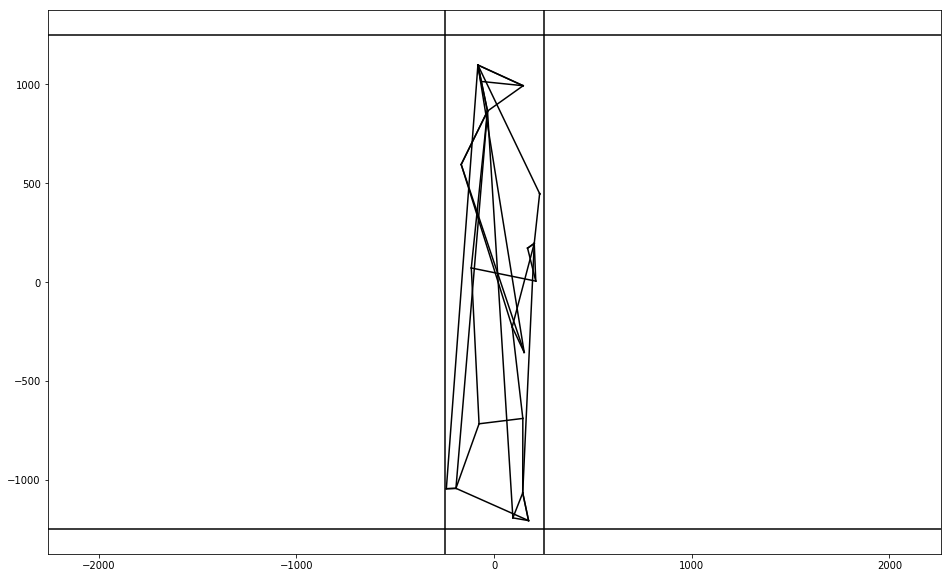

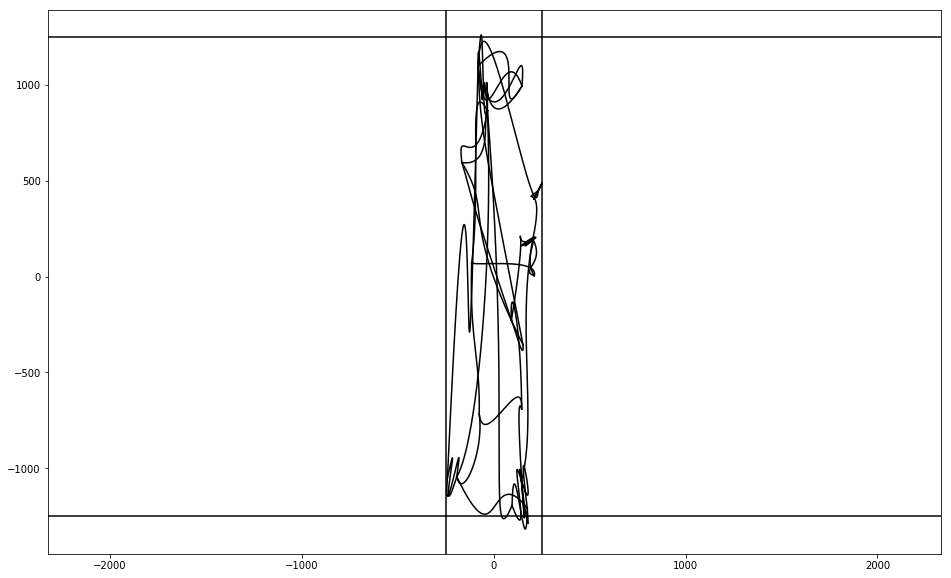

In [170]:
# initialize bounds for generator
x_bounds = [-250,250]
y_bounds = [-1250,1250]

# initialize bounds for heuristic
bounds = [(250, -1250), (250, 1250), (-250, 1250), (-250, -1250)]

# initialized arrays of best values/params
best1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
best_params1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# generate 10,000 parks and keep the best 10 based on the heuristic
for ii in range(10000):

    if ii%1000 == 0:
        print (ii, "/10000")
    
    nodes, paths, bezier = generator(x_bounds, y_bounds, num_nodes=20)
    val = heuristic(nodes, paths, bezier, bounds)
    if val > min(best1):
        minind = best1.index(min(best1))
        best1[minind] = val
        best_params1[minind] = [nodes,paths,bezier]
    
print (best1)

# plotting of best park 
parkstr = 'bestpark10k20'
bestOne = best1.index(max(best1))
print (bestOne, best1[bestOne])
plot_park(best_params1[bestOne][0], best_params1[bestOne][1], parkstr)
plot_bezier_park(best_params1[bestOne][2], 3, parkstr)

2.766860665604142


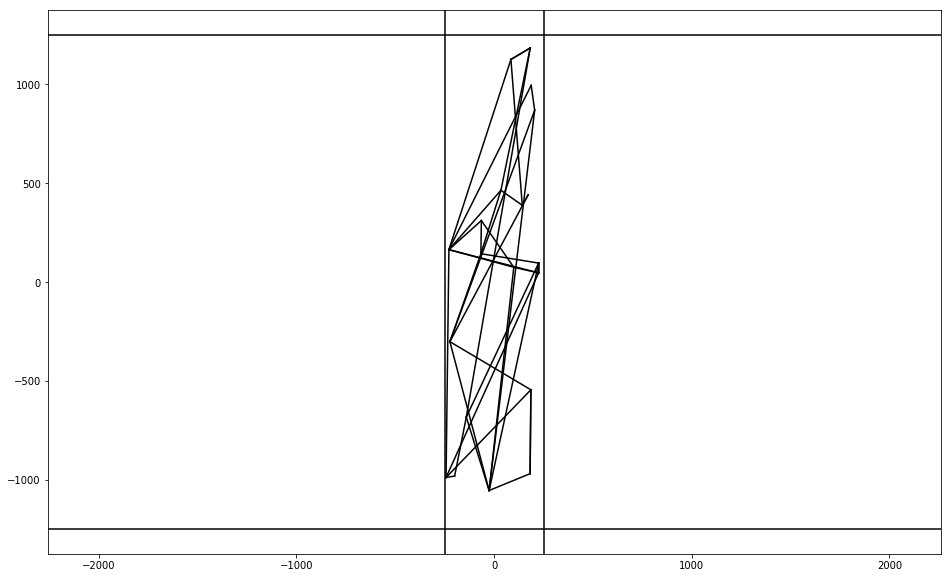

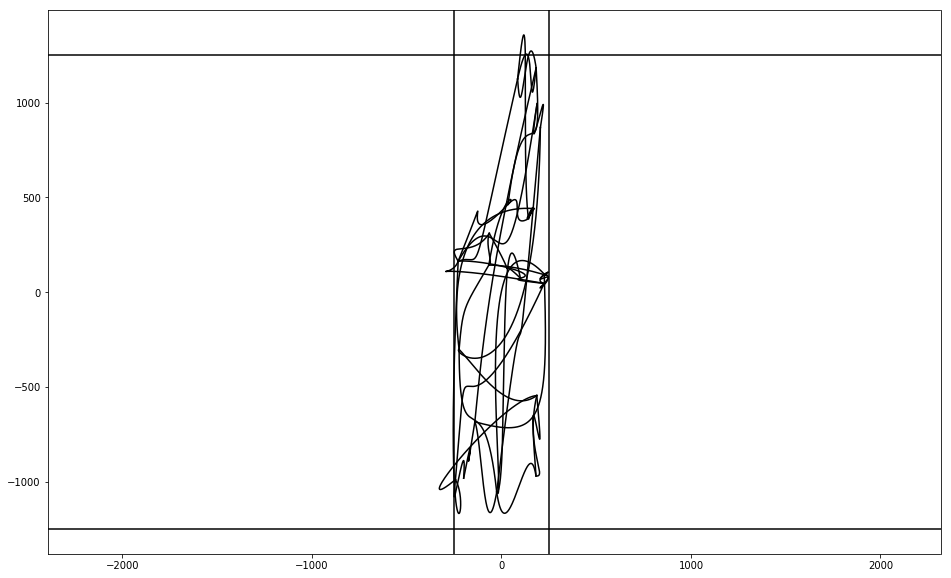

In [174]:
# plotting of other good parks and perturbed iterations
parkstr = 'goodpark10k20'
parkstr1 = 'goodpark10k20perturbed5'
whichone = 1
print (best1[whichone])
plot_park(best_params1[whichone][0], best_params1[whichone][1], parkstr)
plot_bezier_park(best_params1[whichone][2], 3, parkstr)

In [175]:
# rudementary process of pruturbing/evaluating multiple times in a row
nodes1, paths1, bezier1 = perturber(best_params1[whichone][0], best_params1[whichone][1], best_params1[whichone][2], bounds)
val = heuristic(nodes1, paths1, bezier1, bounds)
print (val)
nodes2, paths2, bezier2 = perturber(nodes1, paths1, bezier1, bounds)
val = heuristic(nodes2, paths2, bezier2, bounds)
print (val)
nodes3, paths3, bezier3 = perturber(nodes2, paths2, bezier2, bounds)
val = heuristic(nodes3, paths3, bezier3, bounds)
print (val)
nodes4, paths4, bezier4 = perturber(nodes3, paths3, bezier3, bounds)
val = heuristic(nodes4, paths4, bezier4, bounds)
print (val)
nodes5, paths5, bezier5 = perturber(nodes4, paths4, bezier4, bounds)
val = heuristic(nodes5, paths5, bezier5, bounds)
print (val)

2.7299514037407464
2.6065235847638664
2.672199155224141
2.6924473607993424
2.5472814895625144


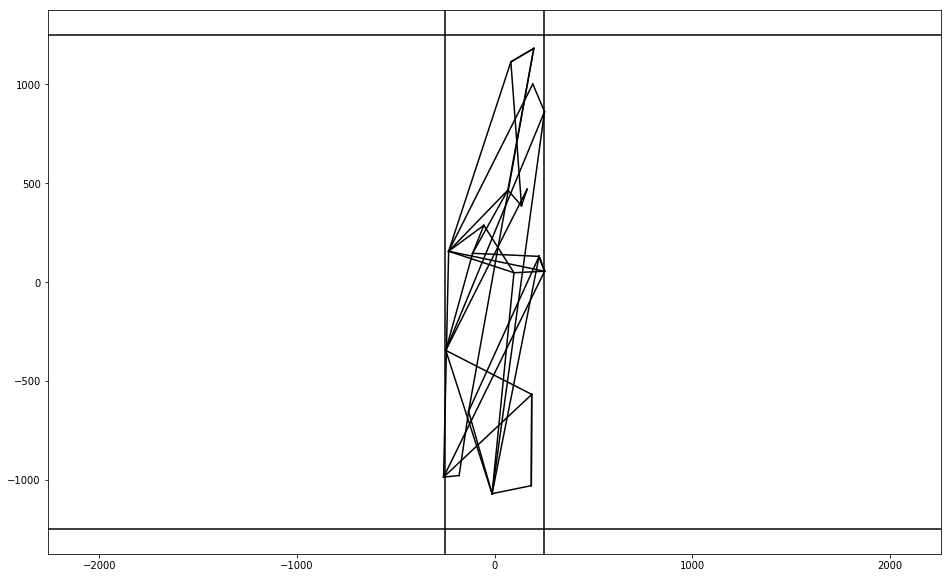

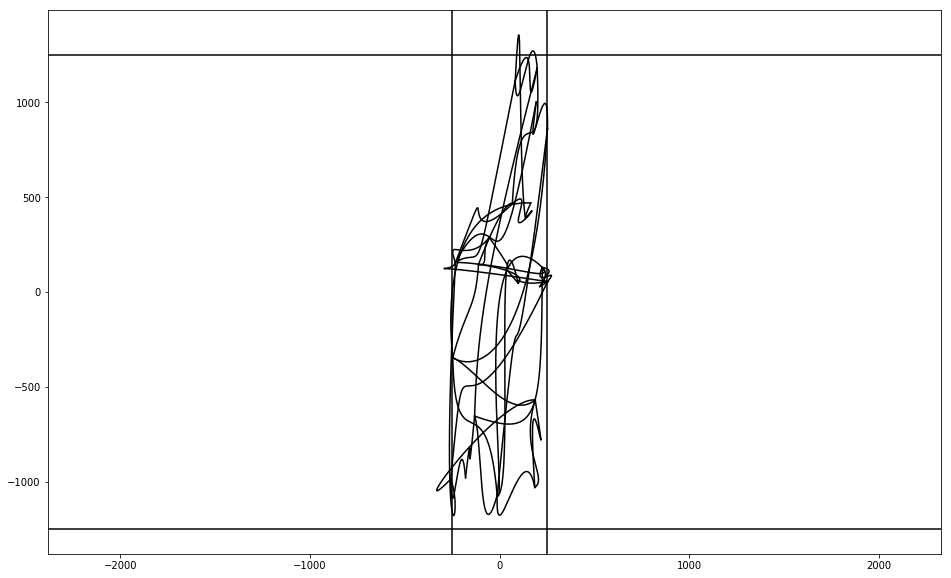

In [176]:
# final plotting of perturbed parks
plot_park(nodes5, paths5, parkstr1)
plot_bezier_park(bezier5, 3, parkstr1)